## Imports

In [1]:
import json
import os
import sys
from collections import defaultdict
import glob
from pprint import pprint
from os import PathLike
from statistics import mean
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from g_index import Experiment
from node_utils import node_divergence
from utils import *
from ipywidgets import interact,FloatLogSlider,IntSlider,FloatSlider
import ipywidgets as widgets


#Experiment Settings
EXP_ROOT = '../experiments/'
EXP_FILES = glob.glob(EXP_ROOT+"/*.json")
DD_CACHE = cache_dd()
DOMAIN_LENGTHS = get_domain_lengths(AVAILABLE_DOMAINS)

##Plot Settings
ALPHA,S=0.90,240
plt.rcParams.update({
    "figure.figsize":(16,9),
    "font.size": 24,
    "lines.color": "black",
    "patch.edgecolor": "white",
    "axes.edgecolor": "0.15",
    "axes.linewidth":1.25,
    "axes.grid":True,
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white",
    "xtick.major.size":20,
    'legend.fontsize': 20,
    'legend.handlelength': 2,
    'axes.titlesize':22
    })

colors = ["#375E97","#FB6542","#FFBB00","#3F681C"]
sim_colors = ["#C03221","#A049AB","#3C28B8","#545E75","#3F826D"]
models = ['gpt2-774M','gpt2-345M','gpt2-1.5B','gptneo-2.7B']
model_colormap = {model:color for color,model in zip(colors,models) }
model_name_correction = {'gpt2-medium': 'gpt2-345M',
                   'gpt2-large': 'gpt2-774M',
                   'gpt2-xl': 'gpt2-1.5B',
                   'EleutherAI gpt-neo-2.7B': 'gptneo-2.7B'}

## 1. Domains

### What are domains

TODO

### List of Available Domains

In [ ]:
for i,domain in enumerate(AVAILABLE_DOMAINS):
    print(i," ",domain)

### What is Domain Distance

TODO

### Calculating Domain Distance between two domains

TODO

In [ ]:
domain_1 = 'telegram-2-reply'
domain_2 = 'telegram-3-reply'

calculate_dd(domain_1,domain_2,verbose=True)

### Calculating Domain Distance between two JSON files

TODO

In [ ]:
domain_1 = '../domains/youtube-pause/youtube-pause-6e696d.json'
domain_2 = '../domains/facebook/facebook-b4ee9a.json'

calculate_dd(domain_1,domain_2,verbose=True)

### Plotting the Domain Distance Matrix

In [ ]:
sns.set(rc={'figure.figsize':(16,12)})
generate_dd_matrix()

## 2. Experiments

### What is an Experiment? 

TODO

### Components of an experiment

The Major Components of an experiment are:
1. Intelligent System(`IS`): 
2. Curricula Domains: 
3. Task Domains:
4. Experience(`E`):
5. Generalization Difficulty( `GD` ): 
6. Performance Details 

In [ ]:
EXP_FILES

In [ ]:
exp_file = EXP_FILES[0]
exp = Experiment(exp_file)
exp.get_exp_components(truncate_domains=True,print_members=True)

## 3. g-index

### What is `g-index`?

TODO

### Calculating `g-index` from an experiment files

Steps:
1. Load an Experiment file in the Experiment Class
2. Run `calculate_g_index` function

In [ ]:
exp_file = EXP_FILES[0]
exp = Experiment(exp_file)
exp.get_exp_components(print_members=True,truncate_domains=True)

In [ ]:
#Use `calculate_g_index` to calculate the value for this experiment
exp.calculate_g_index()

### Calculating `g-index` from Values

`g-index` can be calculated by
- The Ipywidget given below OR
- Create a dummy experiment and give the function `simulate_g_index` the desired values 

In [ ]:
exp = Experiment()

In [ ]:
#Create a dummy Experiment Class
style = {'description_width': '100px'}
interact(exp.simulate_g_index,
         n_tasks_domain=widgets.IntSlider(value=5,min=1,max=100,step=1,description="Samples per Task domain",style=style), 
         n_curricula_domain=IntSlider(value=5,min=1,max=100,step=1,description="Samples per Curricula domain",style=style),
         sim_GD=FloatSlider(value=0.0,min=0.0,max=1.00,step=0.01,description="Generalization Difficulty",style=style), 
         sim_P=FloatLogSlider(value=-3,min=-10,max=10,step=1,description="Prior",style=style),
         sim_E=FloatLogSlider(value=1,min=1,max=12,step=1,description="Experience",style=style),
         sim_PTheta=FloatSlider(value=0.1,min=0.00,max=1.00,step=0.01,description="Performance θ",style=style));

## 4. Reproducing results mentioned in the paper

### Section-3 Simulation Plots

TODO

#### g-index vs Training Samples ( for varying $\theta$ ) 

In [ ]:
ns_curricula_domain = [ 20 * i for i in range(1,33) ] #No of Samples per domain from 20 to 640
sim_PthetaValues = np.around(np.arange(0.2, 1.2, 0.2),2).tolist() #Performance Theta Values from 0.2 to 1.0
num_domains = len(AVAILABLE_DOMAINS)
n_tasks_domain = 5
iters_per_domain = 20
sim_E = 1e2 
sim_P = 1e-2
sim_GD = None
dd_cache = cache_dd() # To speed up the simulations by using precalculated domain distances across domains

In [ ]:
results_gt = defaultdict(dict)
for sim_Ptheta in tqdm(sim_PthetaValues):
    dummy_exp = Experiment(dd_cache=dd_cache)
    ns_gi = {"samples_per_domain": [], "g_index": []}
    for ns_per_domain in ns_curricula_domain:
        for _ in range(iters_per_domain):
            #Randomly distribute samples across domains
            CurriculaDistribution = dict(zip(AVAILABLE_DOMAINS, resplit(ns_per_domain, num_domains)))
            g_index = dummy_exp.simulate_g_index(n_tasks_domain=n_tasks_domain, sim_P=sim_P, sim_E=sim_E, sim_PTheta=sim_Ptheta,
                                                 CurriculaDistribution=CurriculaDistribution,sim_GD=sim_GD)
            ns_gi["samples_per_domain"].append(ns_per_domain)
            ns_gi["g_index"].append(g_index)
    results_gt[sim_Ptheta] = ns_gi

In [ ]:
fig,axes = plt.subplots()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
axes.set_xticks([0])
axes.set_yticks([0])
plt.xlim(20,640)
# plt.ylim(30,120)

for idx,sim_Ptheta in enumerate(results_gt.keys()):
    vals = results_gt[sim_Ptheta]
    x = vals['samples_per_domain']
    y = vals['g_index']
    #Curve Smoothing with 3 degree poly
    fx = np.poly1d(np.polyfit(np.array(x),np.array(y),3))
    z = fx(x)
    sns.lineplot(x=x,y=y,ax=axes,legend=False,linewidth=0,color=sim_colors[idx])
    sns.lineplot(x=x,y=z,ax=axes,legend=False,linewidth=2,label=f"$\\theta$ = {sim_Ptheta}",color=sim_colors[idx])
plt.legend(loc='upper right',labelcolor='black')
plt.tight_layout()
plt.title(f"{ylabel} vs {xlabel}",loc="center")
plt.show()

#### g-index vs Compute ( for varying $\theta$ ) 

In [ ]:
sim_PthetaValues = np.around(np.arange(0.2, 1.2, 0.2),2).tolist() #Performance Theta Values from 0.2 to 1.0
sim_compute_steps = [ 50*i for i in range(1,31)]
n_samples_per_domain = 40
n_tasks_domain = 5 
num_domains = len(AVAILABLE_DOMAINS)
sim_P = 1e-2
iters_per_compute_step = 5
dd_cache = cache_dd()
sim_GD=None

In [ ]:
results_gcp = defaultdict(dict)

for sim_Ptheta in tqdm(sim_PthetaValues):
    dummy_exp = Experiment(dd_cache=dd_cache)
    gi = {"compute":[],"g_index":[]}
    for sim_E in sim_compute_steps:
         for itp in range(iters_per_compute_step):
                
            CurriculaDistribution = dict(zip(AVAILABLE_DOMAINS,resplit( n_samples_per_domain,num_domains )))
            g_index = dummy_exp.simulate_g_index(n_tasks_domain=n_tasks_domain, sim_P=sim_P, sim_E=sim_E, sim_PTheta=sim_Ptheta,
                                                 CurriculaDistribution=CurriculaDistribution,sim_GD=sim_GD)
            gi["compute"].append(sim_E)
            gi["g_index"].append(g_index)
            
    results_gcp[sim_Ptheta] = gi

In [ ]:
ylabel = "g-index"
xlabel = "Compute"

fig,axes = plt.subplots()
plt.xlim(50,1600)
plt.ylim(0,14000)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

axes.set_xticks([0])
axes.set_yticks([0])

for idx,sim_Ptheta in enumerate(results_gcp.keys()):
    vals = results_gcp.get(sim_Ptheta)
    x = vals['compute']
    y = vals['g_index']
    sns.lineplot(x=x,y=y,ax=axes,legend=False,linewidth=0,color=sim_colors[idx])
    sns.lineplot(x=x,y=y,ax=axes,legend=False,linewidth=2,label=f"$\\theta$ = {sim_Ptheta}",color=sim_colors[idx])


plt.legend(loc='upper right',labelcolor='black')
plt.tight_layout()
plt.title(f"{ylabel} vs {xlabel}",loc="center")
plt.show()

#### G-index vs $\theta$ ( for varying $\Omega$ ) HeatMap

In [2]:
sim_PthetaValues = np.around(np.linspace(0.00, 1, 50),2)
n_tasks_domain = 5 
n_curricula_domain = 40
num_domains = len(AVAILABLE_DOMAINS)

sim_E = 1e2
sim_P=1e-2
n_iters_per_temp = 10
dd_cache = cache_dd()
sim_GD=None

In [5]:
results_gt = defaultdict(dict)

for sim_PTheta in tqdm(sim_PthetaValues):
    gi_dd = {"theta":[],"g_index":[],"domain_distance":[]}
    dummy_exp = Experiment()
    for _ in range(n_iters_per_temp):
        
        random_dd = {tA: {tB:val for tB,val in zip( AVAILABLE_DOMAINS, np.clip(np.random.normal(0.5,0.4,16),0,1).tolist() ) } for tA in AVAILABLE_DOMAINS}
        g_index = dummy_exp.simulate_g_index(n_tasks_domain=n_tasks_domain,n_curricula_domain=n_curricula_domain,sim_P=sim_P, sim_E=sim_E, sim_PTheta=sim_PTheta,sim_dd=random_dd)

        gi_dd["theta"].append(sim_PTheta)
        gi_dd["g_index"].append(g_index)
        #get random row and just get it's domain_dist average
        gi_dd["domain_distance"].append(random_row_mean(random_dd))
    results_gt[sim_PTheta] = gi_dd

100%|█████████████████████████████████████| 50/50 [00:18<00:00,  2.71it/s]


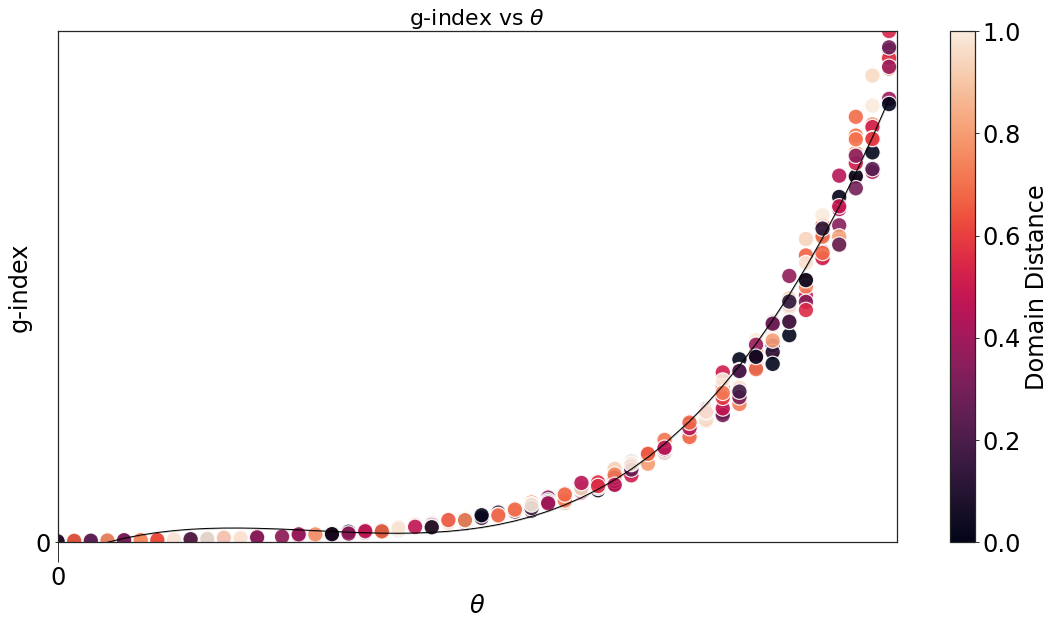

In [10]:
ylabel = "g-index"
xlabel = "$\\theta$"
fig,axes = plt.subplots()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
axes.set_xticks([0])
axes.set_yticks([0])
plt.xlim(0,1.01)
plt.ylim(0,4000)

xtotal,ytotal = [],[] 
for sim_PTheta in results_gt.keys():
    vals = results_gt.get(sim_PTheta)
    x = vals["theta"]
    y = vals["g_index"]
    h = vals["domain_distance"]
    xtotal.extend(x)
    ytotal.extend(y)
    
    sns.scatterplot(x=x,y=y,hue=h,ax=axes,legend=False,s=S,alpha=ALPHA,palette='rocket')
fx = np.poly1d(np.polyfit(np.array(xtotal),np.array(ytotal),3))
z = fx(xtotal)

sns.lineplot(x=xtotal,y=z,ax=axes,legend=False,linewidth=1,color='black')
sm = plt.cm.ScalarMappable(cmap='rocket')
axes.figure.colorbar(sm).set_label(label='Domain Distance')

plt.tight_layout()
plt.title(f"{ylabel} vs {xlabel}",loc="center")
plt.show()

### Section-4 Experiment Plots

#### Average Performance ( $\theta$ )  vs Training Samples

In [ ]:
results = {"IS":[],"avg_perf":[],"total_samples":[],"g_index":[]}
for exp_file in EXP_FILES:
    exp = Experiment(exp_file)    
    exp_c = exp.get_exp_components()
    avg_perf = exp_c.AveragePerformance
    IS = exp_c.IS
    CurriculaDomains = exp_c.CurriculaDomains
    total_samples = sum( [ domain['num_samples'] for domain in CurriculaDomains])
    g_index = exp.calculate_g_index()
    
    results['IS'].append(IS)
    results['avg_perf'].append(avg_perf)
    results['total_samples'].append(total_samples)
    results['g_index'].append(g_index)

In [ ]:
gi = results['g_index']
g_i_dots_scales = [ scale_dots( min(gi), c) for c in gi ]
data_list = [ [x,y,model_name,marker_size] for (x,y,model_name,marker_size) in zip(results['total_samples'],results['avg_perf'],results['IS'],g_i_dots_scales) ]

In [ ]:
fig,axes = plt.subplots()
ylabel = "$\\theta$"
xlabel = "Training Samples"
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.ylim(0,1)

for entry in data_list:
    color = model_colormap[model_name_correction[entry[2]]]
    sns.scatterplot(x=[entry[0]],y=[entry[1]],color=color,s=S,alpha=ALPHA)

plt.tight_layout()
#Dummy plot to generate legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in model_colormap.values()]
plt.legend(markers,model_colormap.keys())
plt.title(f"{ylabel} vs {xlabel}",loc="center")
plt.show()

#### Average Domain Performance ( $\theta$ ) vs Program Size

In [ ]:
domains_considered = AVAILABLE_DOMAINS
results_pst = {"IS":[],"domain_name":[],"program_size":[],"theta":[]}

for exp_file in EXP_FILES:
    exp = Experiment(exp_file)
    for domain in domains_considered:
        exp_c = exp.get_exp_components()
        IS = exp_c.IS
        perf_details = exp_c.PerformanceDetails
        perf_details = next( item for item in perf_details if item["name"] == domain )
        program_size = DOMAIN_LENGTHS[domain]
        
        results_pst["IS"].append(IS)
        results_pst["domain_name"].append(domain)
        results_pst["program_size"].append(program_size)
        results_pst["theta"].append( perf_details['performance'])        
df = pd.DataFrame(results_pst).groupby(by=['domain_name','IS']).mean()

In [ ]:
fig,axes = plt.subplots()
xlabel = "Program size"
ylabel = "$\\theta$"
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.ylim(0,1)

rl = list(results_pst.values())
for temp in domains_considered:
    tdf = df.loc[temp]
    tdf = tdf.reindex(list(model_name_correction.keys()))
    x = tdf['program_size']
    y = tdf['theta']
    for model in model_name_correction.keys():
        x = tdf.loc[model]['program_size']
        y = tdf.loc[model]['theta']
        color = model_colormap[model_name_correction[model]]
        sns.scatterplot(x=[x],y=[y],color=color,s=S,alpha=ALPHA)

plt.tight_layout()
#Dummy Plot to Generate Legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in model_colormap.values()]
plt.legend(markers,model_colormap.keys())
plt.title(f"{ylabel} vs {xlabel}",loc="center")
plt.show()

#### Skill level vs Program Size 

In [ ]:
results_def = {"IS":[],"domain_name":[],"program_size":[],"skill_level":[]}
for exp_file in EXP_FILES:
    exp = Experiment(exp_file)
    for domain in domains_considered:
        exp_c = exp.get_exp_components()
        IS = exp_c.IS
        perf_details = exp_c.PerformanceDetails
        perf_details = next( item for item in perf_details if item["name"] == domain )
        program_size = DOMAIN_LENGTHS[domain]
        results_def["IS"].append(IS)
        results_def["domain_name"].append(domain)
        results_def["program_size"].append(program_size)
        results_def["skill_level"].append(perf_details['perfects'])
df = pd.DataFrame(results_def).groupby(by=['domain_name','IS']).mean()

In [ ]:
fig,axes = plt.subplots()
xlabel = "Program size"
ylabel = "Skill level"
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.ylim(0,1)

rl = list(results_def.values())
for domain in domains_considered:
    tdf = df.loc[domain]
    tdf = tdf.reindex(model_name_correction.keys())
    x = tdf['program_size']
    y = tdf['skill_level']
    for model in model_name_correction.keys():
        x = tdf.loc[model]['program_size']
        y = tdf.loc[model]['skill_level']
        color = model_colormap[model_name_correction[model]]
        sns.scatterplot(x=[x],y=[y],color=color,s=S,alpha=ALPHA)

plt.tight_layout()
#Dummy Plot to Generate Legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in model_colormap.values()]
plt.legend(markers,model_colormap.keys())
plt.title(f"{ylabel} vs {xlabel}",loc="center")
plt.show()

#### Compute Vs Average Performance ( $\theta$ ) 

In [ ]:
results_ct = {"IS":[],"avg_perf":[],"compute":[],"g_index":[]}
for exp_file in EXP_FILES:
    exp  = Experiment(exp_file)
    exp_c = exp.get_exp_components(return_raw_experience=True)
    IS = exp_c.IS
    avg_perf = exp_c.AveragePerformance
    compute = exp_c.E
    g_index = exp.calculate_g_index()
    results_ct['IS'].append(model_name_correction[IS])
    results_ct['avg_perf'].append(avg_perf)
    results_ct['compute'].append(compute)
    results_ct['g_index'].append(g_index)

In [ ]:
g_i_dots_scales = [ scale_dots( min(gi), c) for c in results_ct['g_index'] ]
data_list = [ [x,y,marker_size,model_name] for (x,y,marker_size,model_name) in zip(results_ct['compute'],results_ct['avg_perf'],g_i_dots_scales,results_ct['IS']) ]

In [ ]:
fig,axes = plt.subplots()
ylabel = "Performance"
xlabel = "Compute"
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.ylim(0,1.01)

for entry in data_list:
    sns.scatterplot(x=[entry[0]],y=[entry[1]],color=model_colormap[entry[3]],s=entry[2],alpha=0.85)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in model_colormap.values()]
plt.legend(markers,model_colormap.keys())
plt.tight_layout()
plt.title(f"{ylabel} vs {xlabel}",loc="center")
plt.show()

## 5. Request the data

You can send us a mail at [humans@mayahq.com](mailto:humans@mayahq.com) breifly describing your use case to get the data.

## 6. Cite us!

TODO